In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP
# using BenchmarkTools
using Optim

In [67]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

# Load Data:

In [3]:
conv_mat = load("../data/experiment/m2/conv_matrix-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_3"],
);


# Likelihood Function:

In [71]:
param = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [46,50,20,115], # alignment X
        μ_y = [48,50,25,160], # alignment Y
        σ_x = [1,3,6,10], # resolution X
        σ_y = [1,3,6,10], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );

event = generate_event(param, 25.0, conv_matrices)

(cam_1 = [16 5 … 26 4; 180 33 … 0 113; … ; 0 11 … 0 4; 0 2 … 8 257], cam_2 = [9 5 … 0 1; 0 3 … 1 2; … ; 4 3 … 1 1; 0 0 … 7 0], cam_3 = [25 78 … 11 4; 25 14 … 7 10; … ; 1 5 … 2 2; 6 13 … 6 5], cam_4 = [230 1 … 16 0; 227 5 … 4 134; … ; 5 67 … 62 8; 25 23 … 127 188], population = 25.0)

In [ ]:
# Generate 5 simulated Events: 

# sim_events = [generate_event(param, 25.0, conv_matrices) for i in 1:5]

# FileIO.save("../data/experiment/m2/simulated_events.jld2", 
#     Dict("array" => sim_events))

In [92]:
images = load("../data/experiment/m2/images-2.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)

param = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [46,50,20,115], # alignment X
        μ_y = [48,50,25,160], # alignment Y
        σ_x = [2,2,2,5], # resolution X
        σ_y = [2,2,2,5], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );


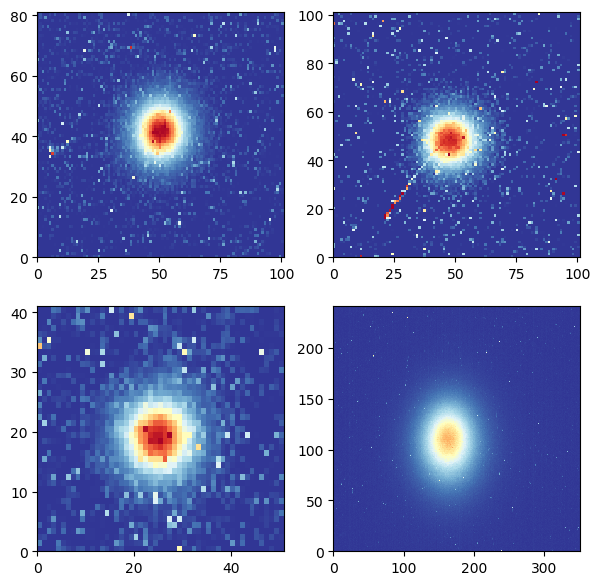

PyObject <matplotlib.collections.QuadMesh object at 0x7fd491c68450>

In [93]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event[1], cmap="RdYlBu_r")
ax[1,2].pcolormesh(event[2], cmap="RdYlBu_r")
ax[2,1].pcolormesh(event[3], cmap="RdYlBu_r")
ax[2,2].pcolormesh(event[4], cmap="RdYlBu_r")

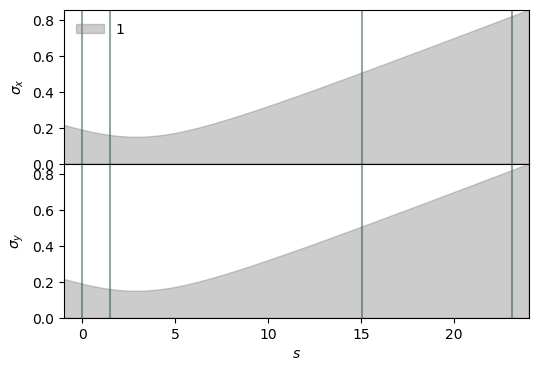

PyObject Text(0.5, 24.0, '$s$')

In [73]:
plot_envelop_trajectory([param,])

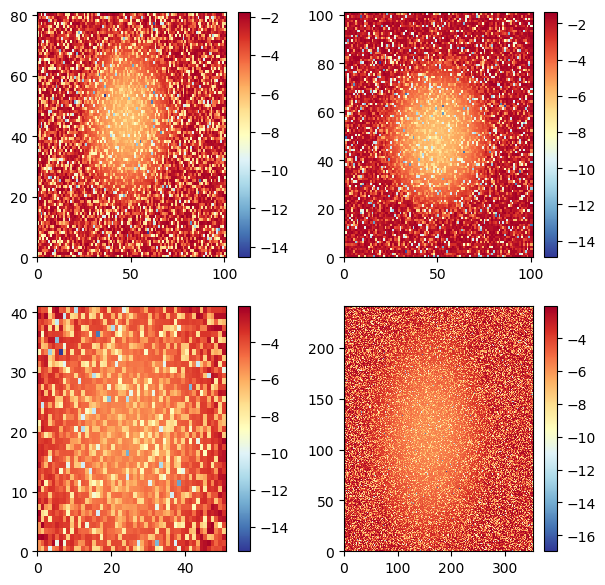

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5036763d0>

In [74]:
log_lik_1 = cam_likelihood_debug(param, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(param, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(param, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(param, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])


In [75]:
# @benchmark total_likelihood($param, $toy_event, $conv_matrices)

total_likelihood(param, event, conv_matrices)

-480597.72922323225

# Optimization:

In [77]:
function vect_to_nt(x::AbstractVector)
    return (
        tr_size = [x[1],x[2]],
        ang_spr = [x[3], x[4]],
        s_waist = [x[5],],
        μ_x = [x[6],x[7],x[8],x[9]], 
        μ_y = [x[10],x[11],x[12],x[13]], 
        σ_x = [x[14],x[15],x[16],x[17]], 
        σ_y = [x[18],x[19],x[20],x[21]], 
        δ_x = [x[22],x[23],x[24],x[25]], 
        δ_y = [x[26],x[27],x[28],x[29]], 
        int_coeff  = [x[30],x[31],x[32],x[33]], 
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    )
end

function nt_to_vect(x::N) where {N <: NamedTuple}
    return [
        x.tr_size..., 
        x.ang_spr..., 
        x.s_waist..., 
        x.μ_x..., 
        x.μ_y..., 
        x.σ_x..., 
        x.σ_y..., 
        x.δ_x..., 
        x.δ_y..., 
        x.int_coeff...,
    ]
end

function opt_function(x; event=event, cv = conv_matrices)
    nt = vect_to_nt(x)
    return abs.(total_likelihood(nt, event, cv))
end

opt_function (generic function with 1 method)

In [84]:
param_1 = (
        tr_size = [0.20, 0.20],
        ang_spr = [4.0, 4.0],
        s_waist = [2.5,],
        μ_x = [46,50,20,115], # alignment X
        μ_y = [48,50,25,160], # alignment Y
        σ_x = [1,3,6,10], # resolution X
        σ_y = [1,3,6,10], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );

x_0 = nt_to_vect(param_1)

opt_output = optimize(opt_function, x_0)

opt_parameters = vect_to_nt(opt_output.minimizer);

In [85]:
opt_output.minimizer

33-element Array{Float64,1}:
      0.19179935811538484
      0.19254780466084037
      4.00366869720538
      4.046907031336698
      2.3618999703217756
     46.007614003758135
     50.012105709576744
     20.029149359914495
    114.97503181326864
     48.016795923637694
     50.00565685355441
     24.97767917890883
    159.98507929627974
      ⋮
      0.030279035174473955
      0.025994058005197683
      0.12451224146296219
      0.030976713184038482
      0.034450995902510925
      0.02825739837088899
      0.1423339591117126
      0.03080486973796422
  34974.743872212915
  50537.67775281756
  10420.97087732956
 313027.9942992107

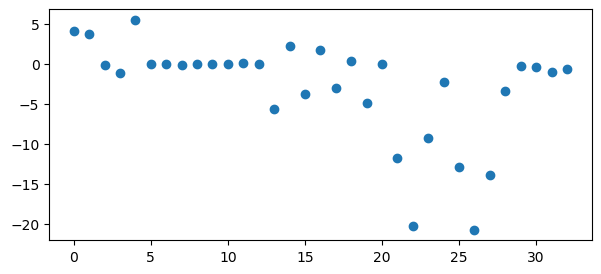

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5610928d0>

In [86]:
per_div = 100 .* (x_0 .- opt_output.minimizer) ./ x_0

fig, ax = plt.subplots(1,1, figsize=(7,3))

ax.plot(per_div, "o")

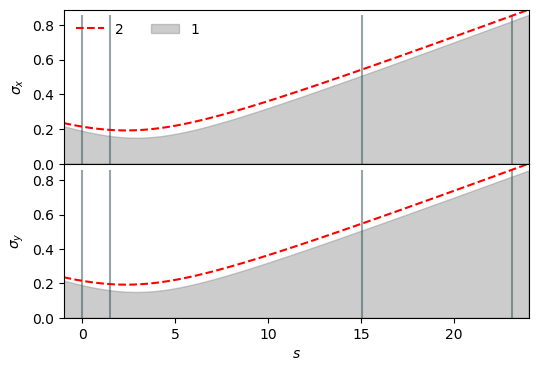

PyObject Text(0.5, 24.0, '$s$')

In [87]:
plot_vector = [param, opt_parameters,]

plot_envelop_trajectory(plot_vector)

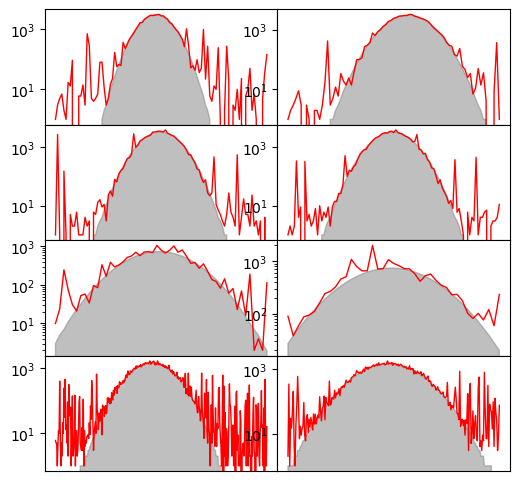

In [88]:
plot_cam_crossections([opt_parameters,], event, conv_matrices)


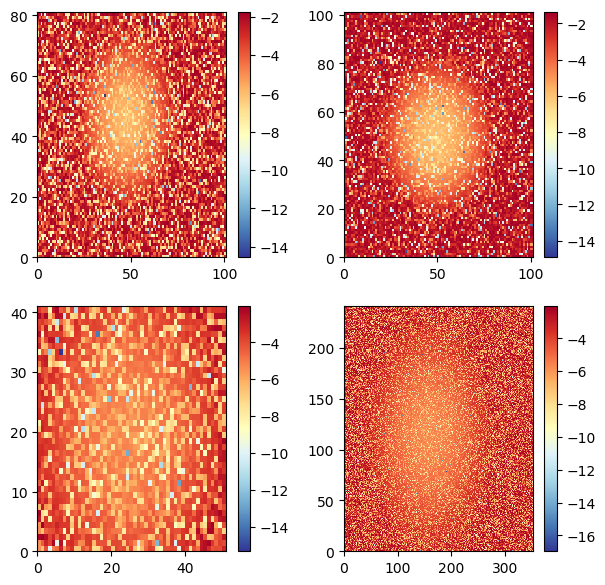

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd4b5f49590>

In [89]:
log_lik_1 = cam_likelihood_debug(opt_parameters, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(opt_parameters, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(opt_parameters, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(opt_parameters, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])
